## **Brain Tumor Classification and Segmentation Using EfficientNet and YOLO**

### Importing Required Libraries

##### pip install -r requirements.txt , install all in cmd prompt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2, VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint # type: ignore
from sklearn.metrics import classification_report, confusion_matrix
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
# Enable Eager Execution
tf.config.run_functions_eagerly(True)
print("Eager execution enabled:", tf.executing_eagerly())

Eager execution enabled: True


### Define colors for visualization


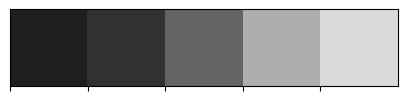

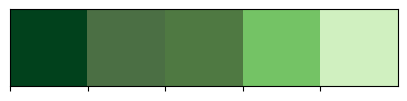

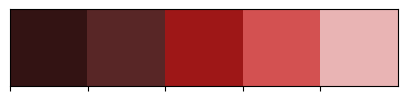

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C', '#4B6F44', '#4F7942', '#74C365', '#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

### Define Labels


In [4]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

### Loading and Preparing Data

In [5]:
image_size = 150
X_train, y_train = [], []

### Load Training Data

In [6]:
for label in labels:
    folder_path = os.path.join('../DataSet', 'Training', label)
    for image_file in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, image_file))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train, y_train = shuffle(X_train, y_train, random_state=101)

100%|██████████| 901/901 [00:03<00:00, 259.40it/s]


### Split Data & Encode Labels

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

y_train = tf.keras.utils.to_categorical([labels.index(label) for label in y_train])
y_test = tf.keras.utils.to_categorical([labels.index(label) for label in y_test])

### Build EfficientNetB0 Model with Adam

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7453 - loss: 0.6550
Epoch 1: val_accuracy improved from -inf to 0.87415, saving model to EfficientNetB0_Adam.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 431s 5s/step - accuracy: 0.7462 - loss: 0.6530 - val_accuracy: 0.8741 - val_loss: 0.5345 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9254 - loss: 0.2110
Epoch 2: val_accuracy did not improve from 0.87415
83/83 ━━━━━━━━━━━━━━━━━━━━ 400s 5s/step - accuracy: 0.9255 - loss: 0.2107 - val_accuracy: 0.8061 - val_loss: 0.6811 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9650 - loss: 0.1011
Epoch 3: val_accuracy improved from 0.87415 to 0.94558, saving model to EfficientNetB0_Adam.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 379s 5s/step - accuracy: 0.9649 - loss: 0.1011 - val_accuracy: 0.9456 - val_loss: 0.3074 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9707 - loss: 0.0877
Epoc

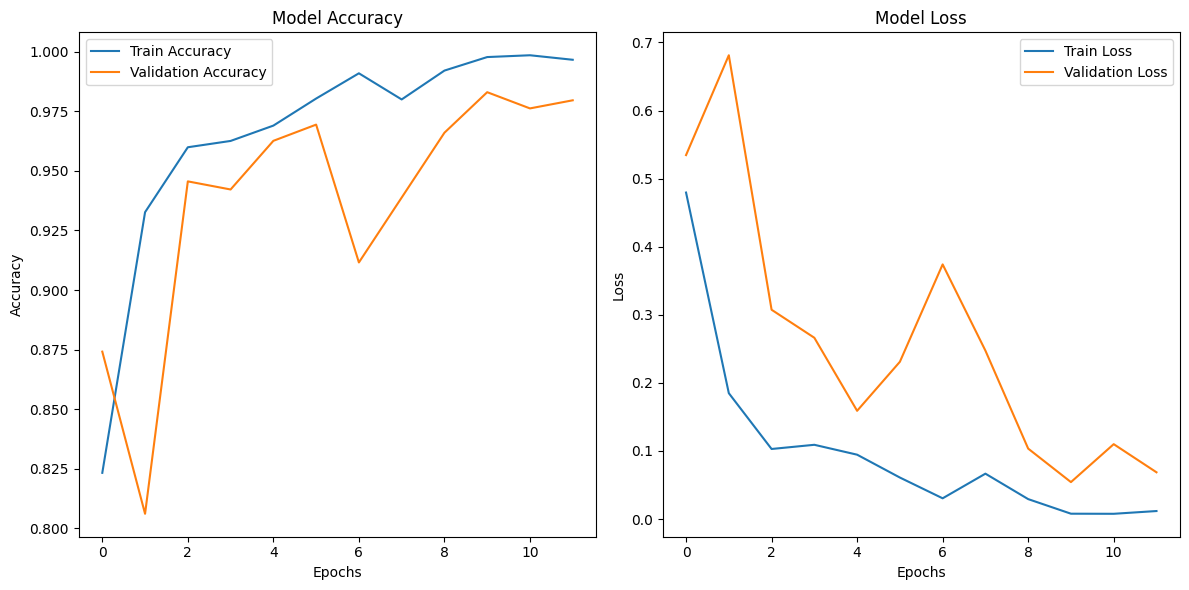

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 734ms/step
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.95      0.96      0.95        98
        no_tumor       1.00      0.98      0.99        49
meningioma_tumor       0.94      0.97      0.95        93
 pituitary_tumor       0.98      0.94      0.96        87

        accuracy                           0.96       327
       macro avg       0.97      0.96      0.96       327
    weighted avg       0.96      0.96      0.96       327



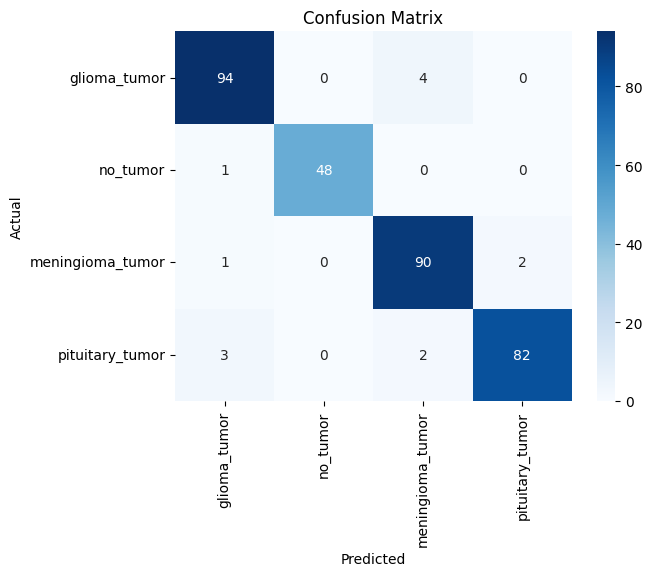

In [9]:
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = tf.keras.Sequential([
    effnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("EfficientNetB0_Adam.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=12,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_test_classes, pred_classes, target_names=labels))
cm = confusion_matrix(y_test_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

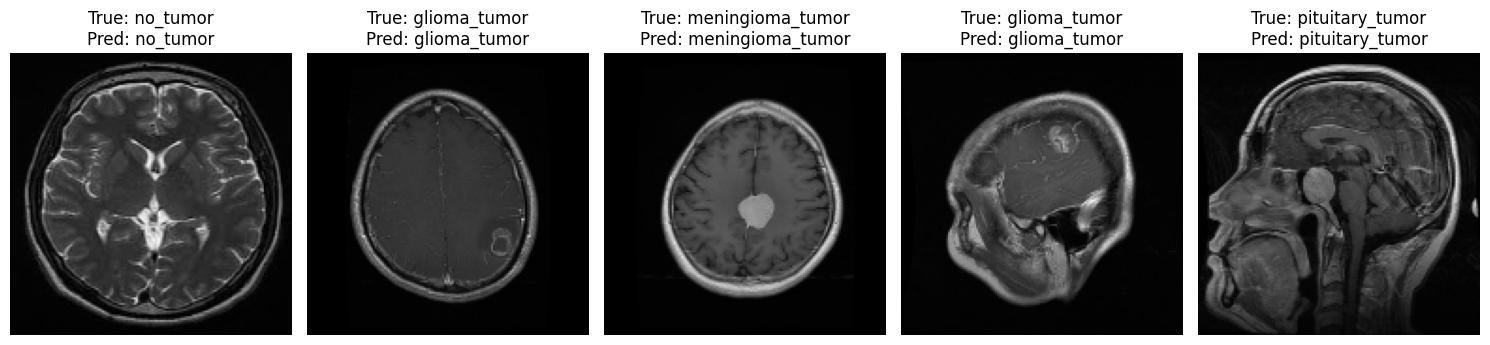

In [11]:
def visualize_predictions(X, y_true, y_pred, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true_label = labels[np.argmax(y_true[idx])]
        pred_label = labels[np.argmax(y_pred[idx])]
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_test, pred, labels)

### Build MobileNetV2 Model with Adam

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6795 - loss: 0.9091
Epoch 1: val_accuracy improved from -inf to 0.18707, saving model to MobileNetV2_Adam.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.6807 - loss: 0.9059 - val_accuracy: 0.1871 - val_loss: 14.8578 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8965 - loss: 0.3221
Epoch 2: val_accuracy did not improve from 0.18707
83/83 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.8965 - loss: 0.3221 - val_accuracy: 0.1871 - val_loss: 15.4681 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9156 - loss: 0.2630
Epoch 3: val_accuracy improved from 0.18707 to 0.19048, saving model to MobileNetV2_Adam.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 294s 4s/step - accuracy: 0.9157 - loss: 0.2627 - val_accuracy: 0.1905 - val_loss: 17.3624 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9245 - loss: 0.2178
Epoch 4

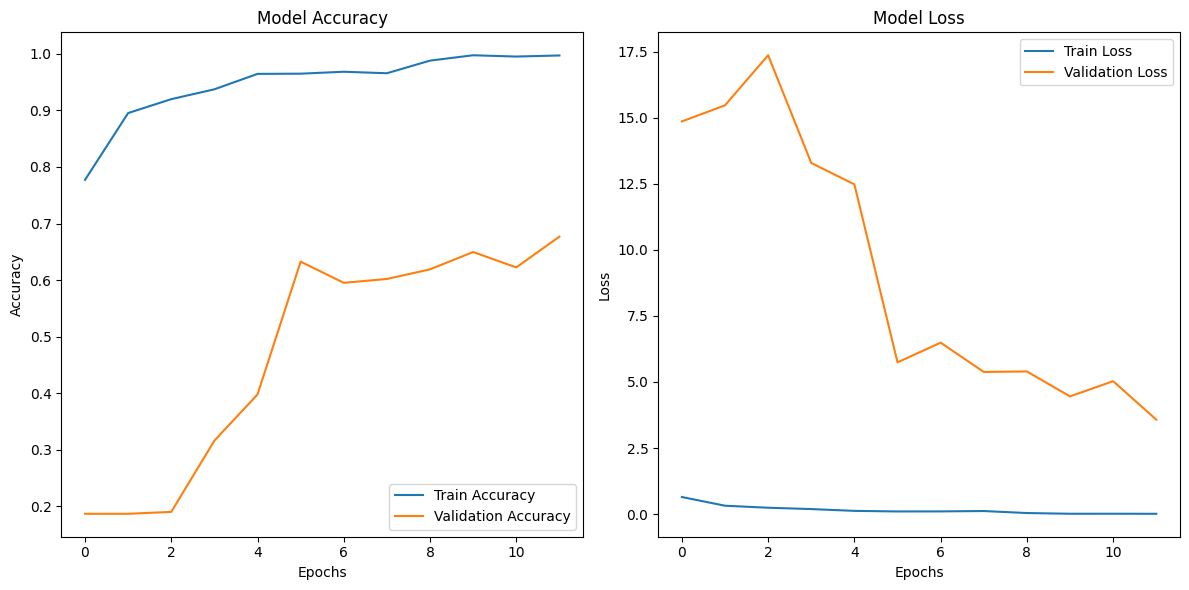

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 677ms/step
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       1.00      0.29      0.44        98
        no_tumor       0.41      1.00      0.58        49
meningioma_tumor       0.92      0.83      0.87        93
 pituitary_tumor       0.86      0.95      0.91        87

        accuracy                           0.72       327
       macro avg       0.80      0.77      0.70       327
    weighted avg       0.85      0.72      0.71       327



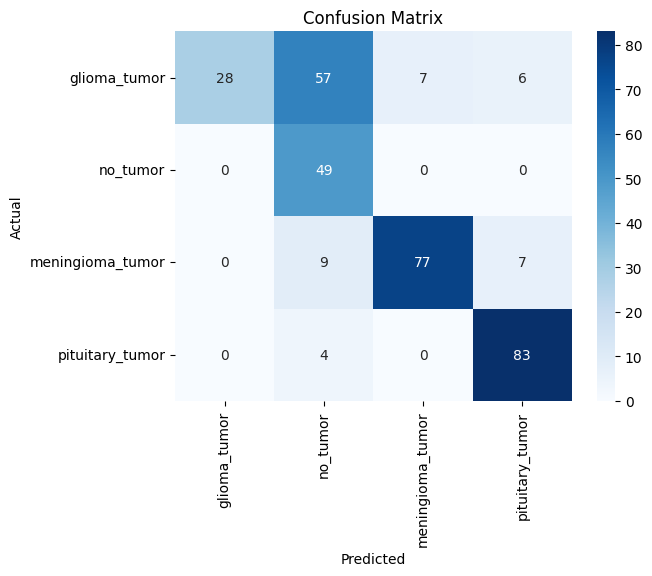

In [12]:
effnet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = tf.keras.Sequential([
    effnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("MobileNetV2_Adam.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=12,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_test_classes, pred_classes, target_names=labels))
cm = confusion_matrix(y_test_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

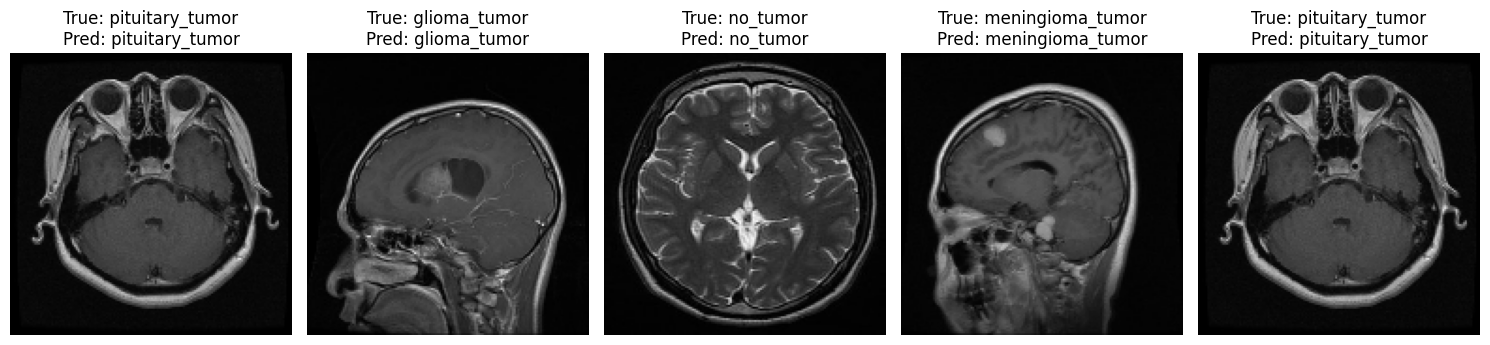

In [13]:
def visualize_predictions(X, y_true, y_pred, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true_label = labels[np.argmax(y_true[idx])]
        pred_label = labels[np.argmax(y_pred[idx])]
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_test, pred, labels)

### Build VGG16 Model with Adam

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2735 - loss: 3.6359
Epoch 1: val_accuracy improved from -inf to 0.30952, saving model to VGG16_Adam.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 518s 6s/step - accuracy: 0.2735 - loss: 3.6178 - val_accuracy: 0.3095 - val_loss: 1.3776 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2930 - loss: 1.3783
Epoch 2: val_accuracy did not improve from 0.30952
83/83 ━━━━━━━━━━━━━━━━━━━━ 557s 7s/step - accuracy: 0.2928 - loss: 1.3783 - val_accuracy: 0.2959 - val_loss: 1.3697 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2689 - loss: 1.3714
Epoch 3: val_accuracy did not improve from 0.30952

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 ━━━━━━━━━━━━━━━━━━━━ 544s 7s/step - accuracy: 0.2689 - loss: 1.3714 - val_accuracy: 0.2789 - val_loss: 1.3635 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.295

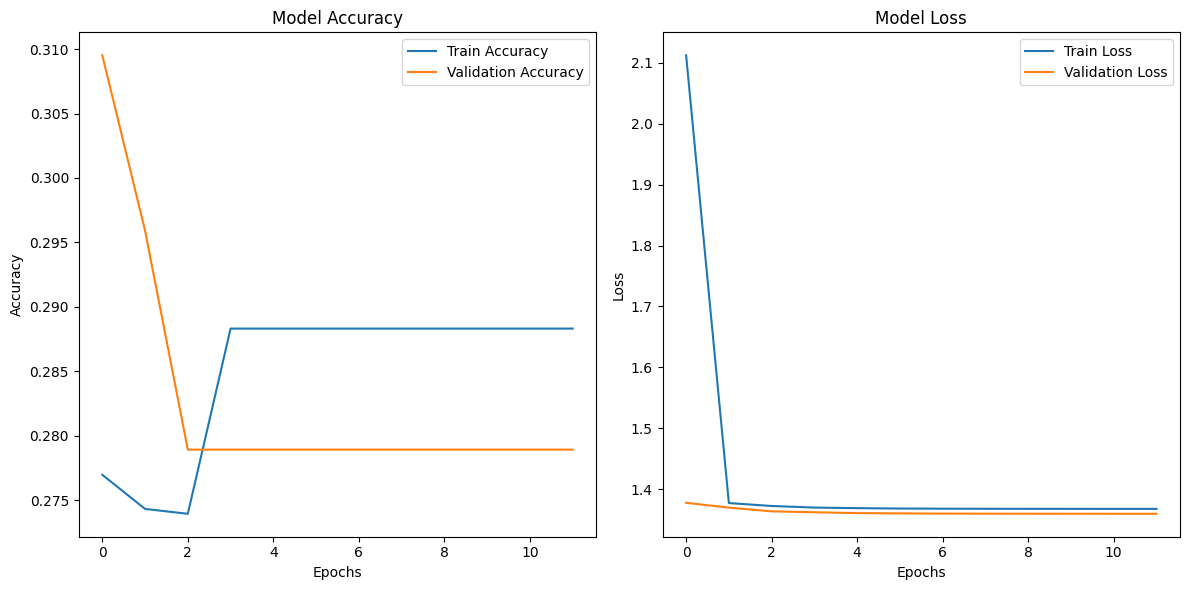

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00        98
        no_tumor       0.00      0.00      0.00        49
meningioma_tumor       0.28      1.00      0.44        93
 pituitary_tumor       0.00      0.00      0.00        87

        accuracy                           0.28       327
       macro avg       0.07      0.25      0.11       327
    weighted avg       0.08      0.28      0.13       327



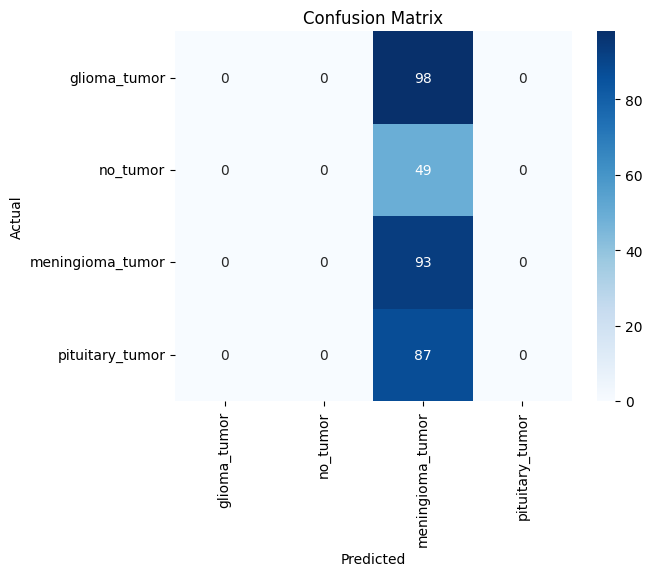

In [14]:
effnet = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = tf.keras.Sequential([
    effnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("VGG16_Adam.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=12,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_test_classes, pred_classes, target_names=labels))
cm = confusion_matrix(y_test_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

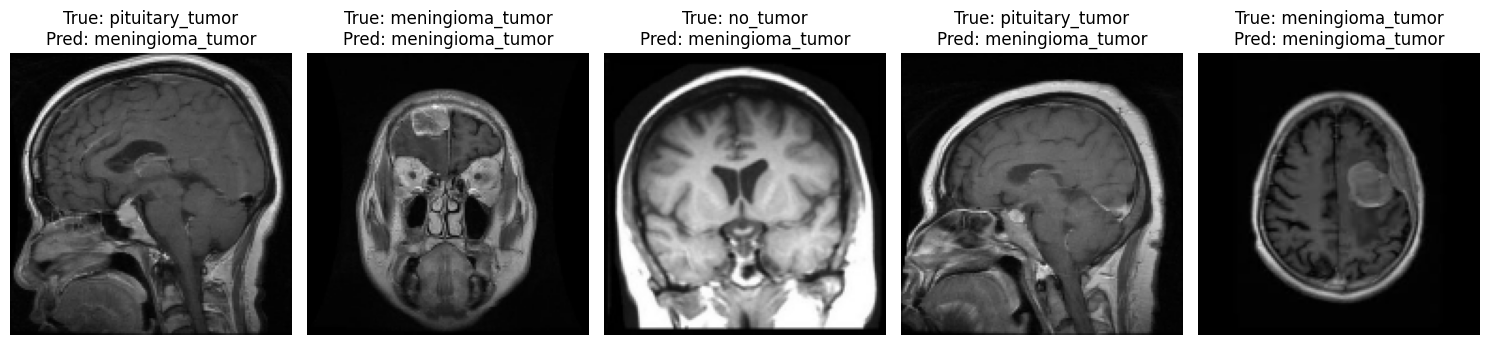

In [15]:
def visualize_predictions(X, y_true, y_pred, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true_label = labels[np.argmax(y_true[idx])]
        pred_label = labels[np.argmax(y_pred[idx])]
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_test, pred, labels)

### Build ResNet50 Model with Adam

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6749 - loss: 0.9272
Epoch 1: val_accuracy improved from -inf to 0.12585, saving model to ResNet50_Adam.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 486s 6s/step - accuracy: 0.6758 - loss: 0.9253 - val_accuracy: 0.1259 - val_loss: 53.5285 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8566 - loss: 0.4160
Epoch 2: val_accuracy improved from 0.12585 to 0.46259, saving model to ResNet50_Adam.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 480s 6s/step - accuracy: 0.8568 - loss: 0.4155 - val_accuracy: 0.4626 - val_loss: 8.1425 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9161 - loss: 0.2377
Epoch 3: val_accuracy improved from 0.46259 to 0.89796, saving model to ResNet50_Adam.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 474s 6s/step - accuracy: 0.9163 - loss: 0.2374 - val_accuracy: 0.8980 - val_loss: 0.3696 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accura

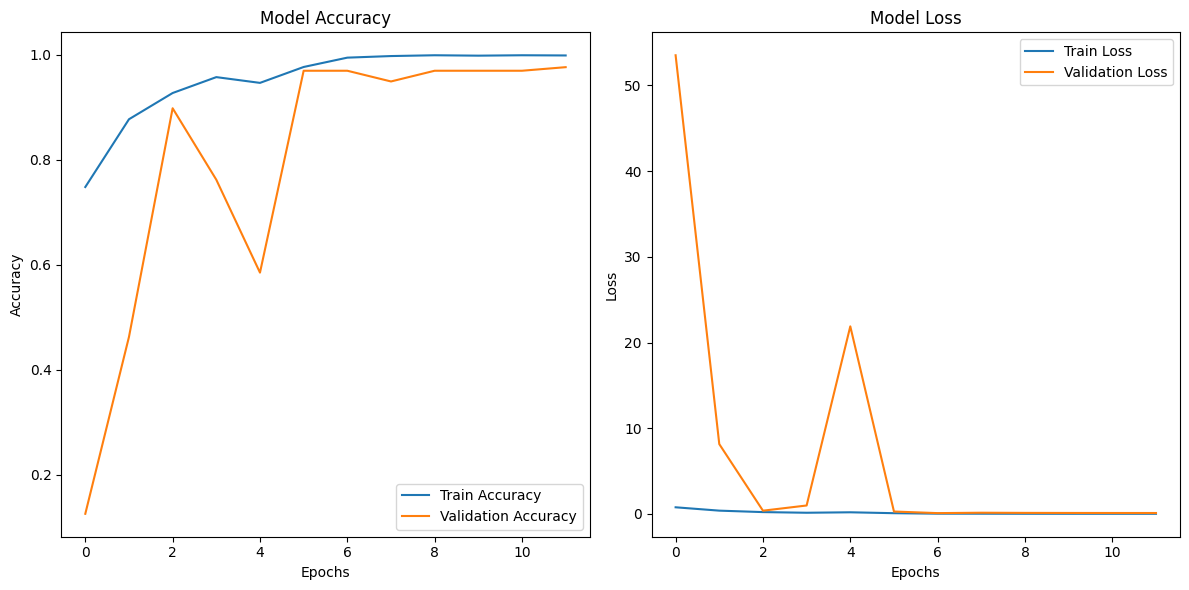

11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.94      0.96        98
        no_tumor       0.98      0.96      0.97        49
meningioma_tumor       0.94      0.98      0.96        93
 pituitary_tumor       0.98      0.99      0.98        87

        accuracy                           0.97       327
       macro avg       0.97      0.97      0.97       327
    weighted avg       0.97      0.97      0.97       327



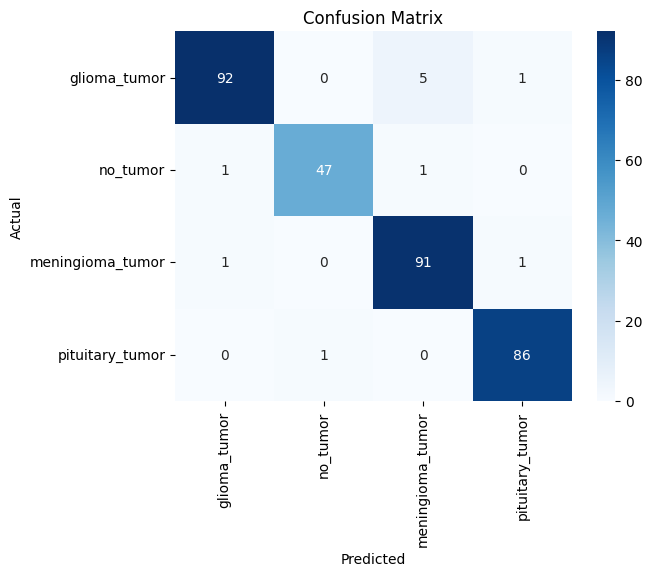

In [16]:
effnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = tf.keras.Sequential([
    effnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("ResNet50_Adam.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=12,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_test_classes, pred_classes, target_names=labels))
cm = confusion_matrix(y_test_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

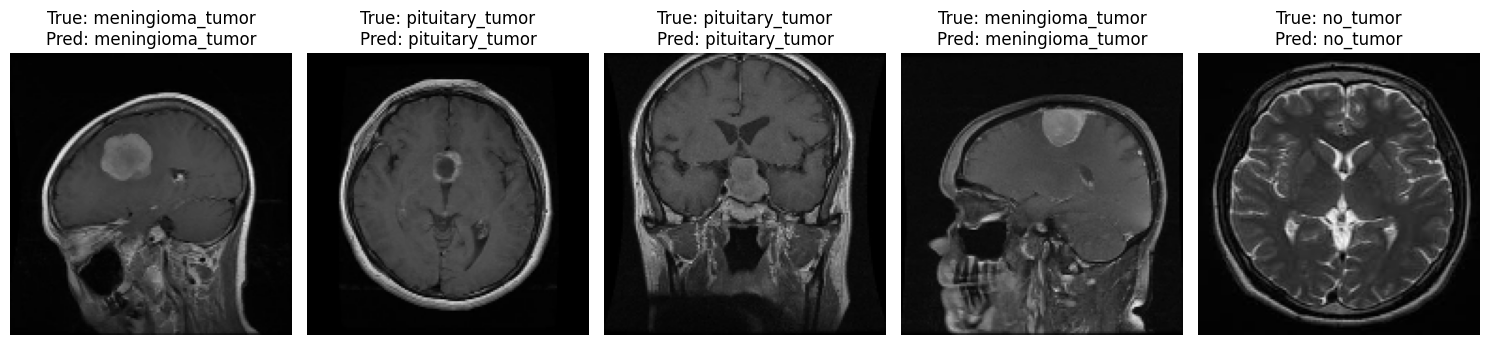

In [17]:
def visualize_predictions(X, y_true, y_pred, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true_label = labels[np.argmax(y_true[idx])]
        pred_label = labels[np.argmax(y_pred[idx])]
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_test, pred, labels)

### Build EfficientNetB0 Model with SGD

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4092 - loss: 1.2771
Epoch 1: val_accuracy improved from -inf to 0.59524, saving model to EfficientNetB0_SGD.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.4108 - loss: 1.2745 - val_accuracy: 0.5952 - val_loss: 0.9761 - learning_rate: 0.0100
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7563 - loss: 0.6465
Epoch 2: val_accuracy improved from 0.59524 to 0.74830, saving model to EfficientNetB0_SGD.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 333s 4s/step - accuracy: 0.7567 - loss: 0.6458 - val_accuracy: 0.7483 - val_loss: 0.7293 - learning_rate: 0.0100
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8591 - loss: 0.4263
Epoch 3: val_accuracy improved from 0.74830 to 0.79932, saving model to EfficientNetB0_SGD.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 333s 4s/step - accuracy: 0.8592 - loss: 0.4261 - val_accuracy: 0.7993 - val_loss: 0.6064 - learning_rate: 0.0100
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s

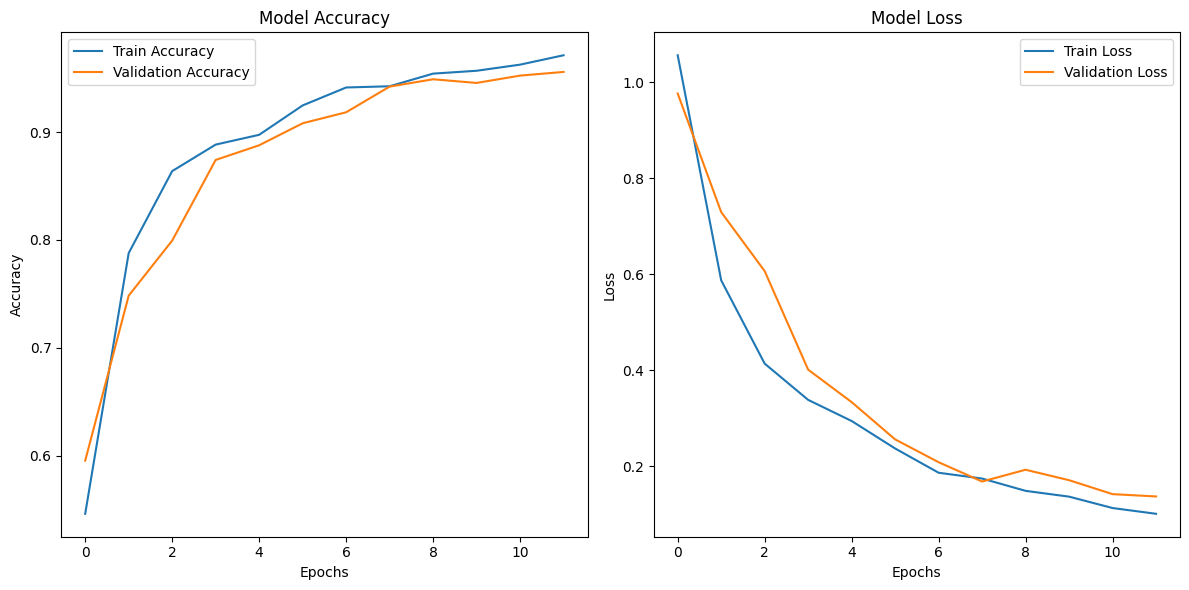

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 724ms/step
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.96      0.93      0.94        98
        no_tumor       1.00      0.96      0.98        49
meningioma_tumor       0.91      0.94      0.92        93
 pituitary_tumor       0.97      0.99      0.98        87

        accuracy                           0.95       327
       macro avg       0.96      0.95      0.96       327
    weighted avg       0.95      0.95      0.95       327



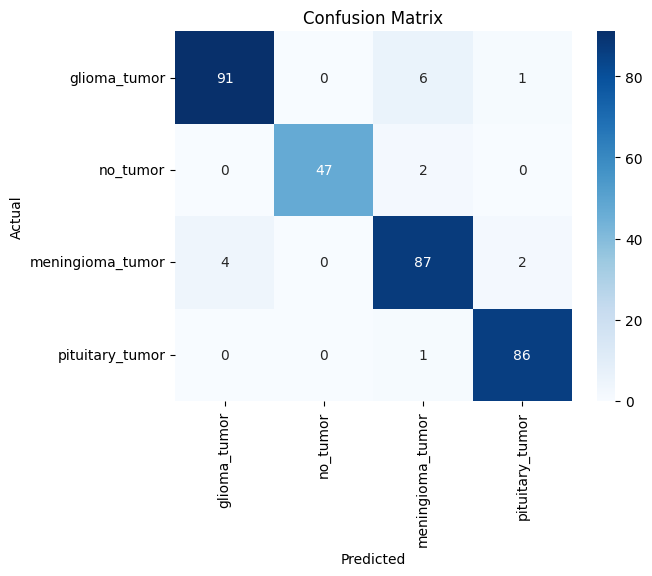

In [18]:
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = tf.keras.Sequential([
    effnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("EfficientNetB0_SGD.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=12,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_test_classes, pred_classes, target_names=labels))
cm = confusion_matrix(y_test_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

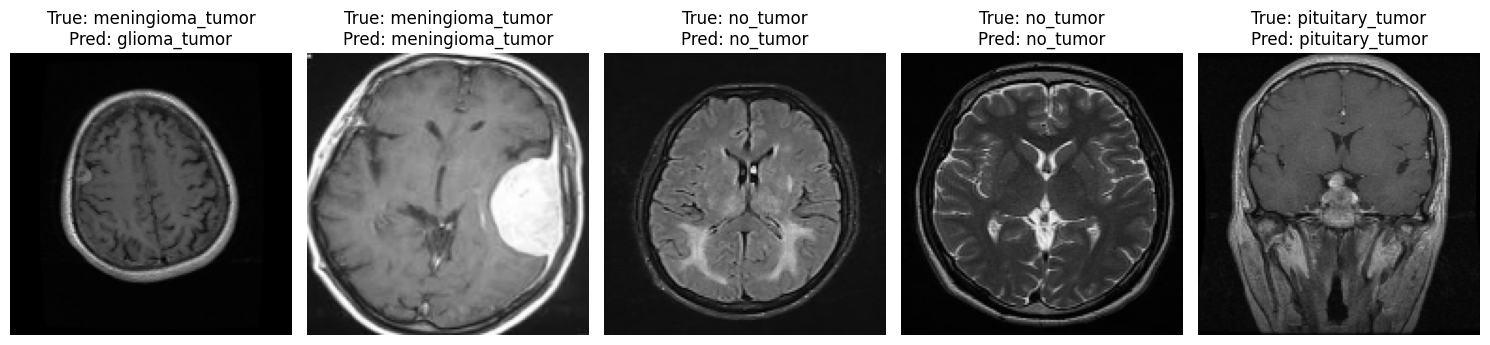

In [19]:
def visualize_predictions(X, y_true, y_pred, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true_label = labels[np.argmax(y_true[idx])]
        pred_label = labels[np.argmax(y_pred[idx])]
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_test, pred, labels)

### Build MobileNetV2 Model with SGD

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6344 - loss: 0.9652
Epoch 1: val_accuracy improved from -inf to 0.35034, saving model to MobileNetV2_SGD.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.6359 - loss: 0.9616 - val_accuracy: 0.3503 - val_loss: 1.9969 - learning_rate: 0.0100
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8995 - loss: 0.2831
Epoch 2: val_accuracy improved from 0.35034 to 0.40476, saving model to MobileNetV2_SGD.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.8996 - loss: 0.2827 - val_accuracy: 0.4048 - val_loss: 1.9208 - learning_rate: 0.0100
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9608 - loss: 0.1240
Epoch 3: val_accuracy improved from 0.40476 to 0.46599, saving model to MobileNetV2_SGD.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.9608 - loss: 0.1240 - val_accuracy: 0.4660 - val_loss: 1.7613 - learning_rate: 0.0100
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - a

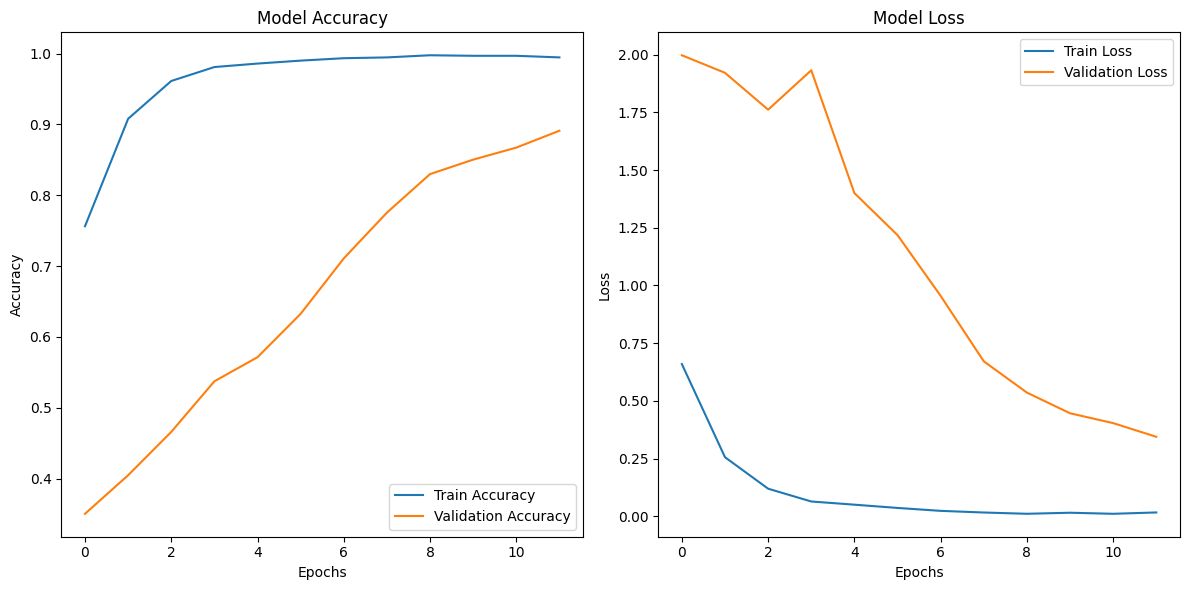

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 418ms/step
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.85      0.93      0.89        98
        no_tumor       0.79      0.98      0.87        49
meningioma_tumor       0.88      0.80      0.84        93
 pituitary_tumor       0.97      0.84      0.90        87

        accuracy                           0.87       327
       macro avg       0.87      0.89      0.87       327
    weighted avg       0.88      0.87      0.87       327



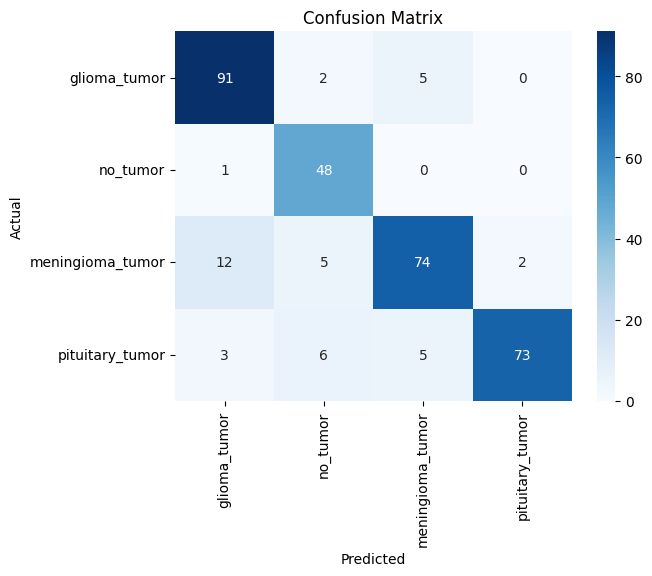

In [20]:
effnet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = tf.keras.Sequential([
    effnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("MobileNetV2_SGD.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=12,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_test_classes, pred_classes, target_names=labels))
cm = confusion_matrix(y_test_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

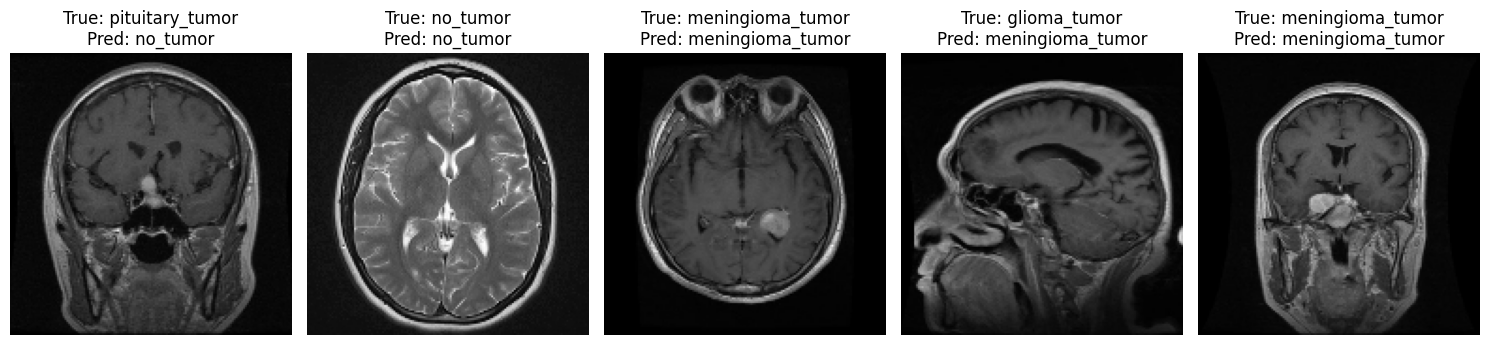

In [21]:
def visualize_predictions(X, y_true, y_pred, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true_label = labels[np.argmax(y_true[idx])]
        pred_label = labels[np.argmax(y_pred[idx])]
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_test, pred, labels)

### Build VGG16 Model with SGD

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2616 - loss: nan
Epoch 1: val_accuracy improved from -inf to 0.29932, saving model to VGG16_SGD.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 470s 6s/step - accuracy: 0.2618 - loss: nan - val_accuracy: 0.2993 - val_loss: nan - learning_rate: 0.0100
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2830 - loss: nan
Epoch 2: val_accuracy did not improve from 0.29932
83/83 ━━━━━━━━━━━━━━━━━━━━ 467s 6s/step - accuracy: 0.2830 - loss: nan - val_accuracy: 0.2993 - val_loss: nan - learning_rate: 0.0100
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2710 - loss: nan
Epoch 3: val_accuracy did not improve from 0.29932

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
83/83 ━━━━━━━━━━━━━━━━━━━━ 478s 6s/step - accuracy: 0.2711 - loss: nan - val_accuracy: 0.2993 - val_loss: nan - learning_rate: 0.0100
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2876 - loss: nan
Epoch 4: val_a

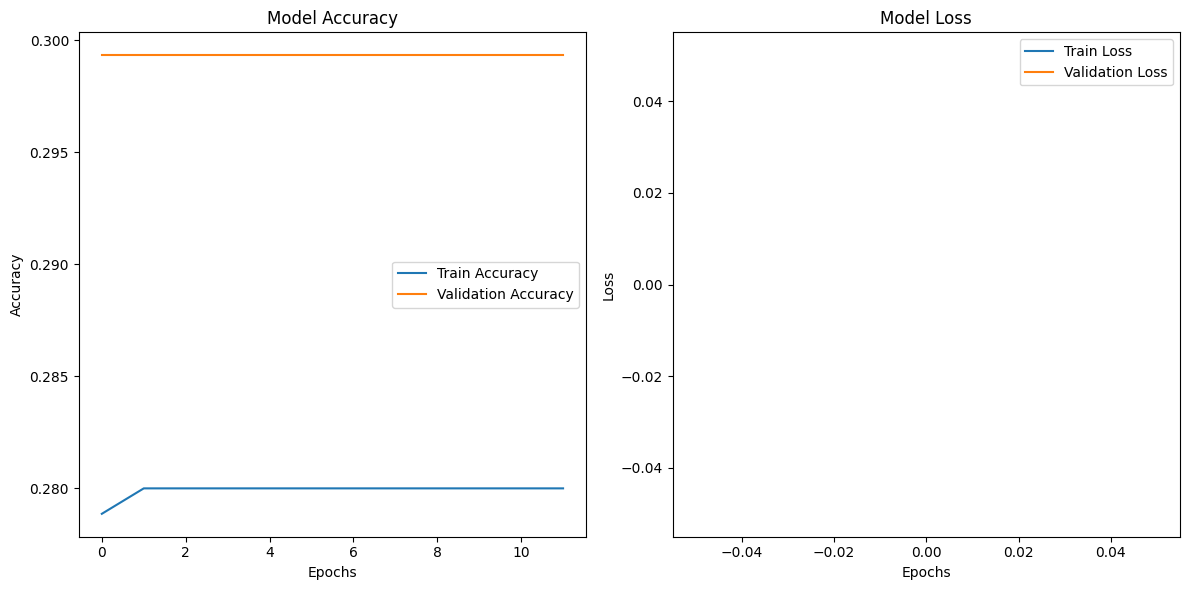

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.30      1.00      0.46        98
        no_tumor       0.00      0.00      0.00        49
meningioma_tumor       0.00      0.00      0.00        93
 pituitary_tumor       0.00      0.00      0.00        87

        accuracy                           0.30       327
       macro avg       0.07      0.25      0.12       327
    weighted avg       0.09      0.30      0.14       327



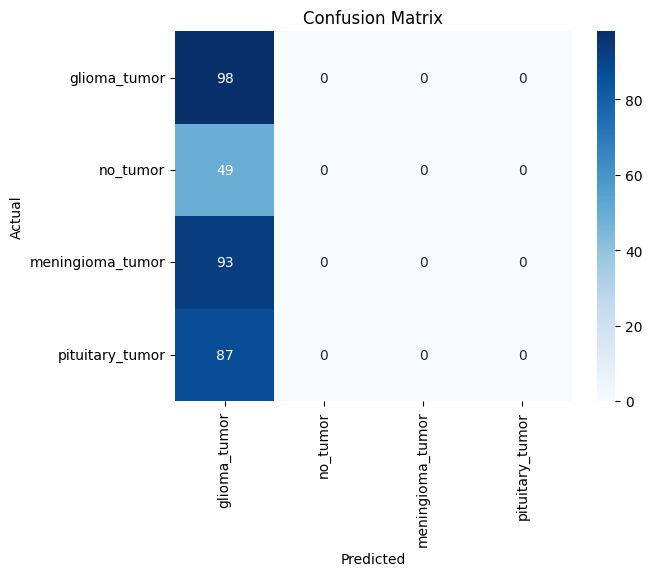

In [22]:
effnet = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = tf.keras.Sequential([
    effnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("VGG16_SGD.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=12,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_test_classes, pred_classes, target_names=labels))
cm = confusion_matrix(y_test_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

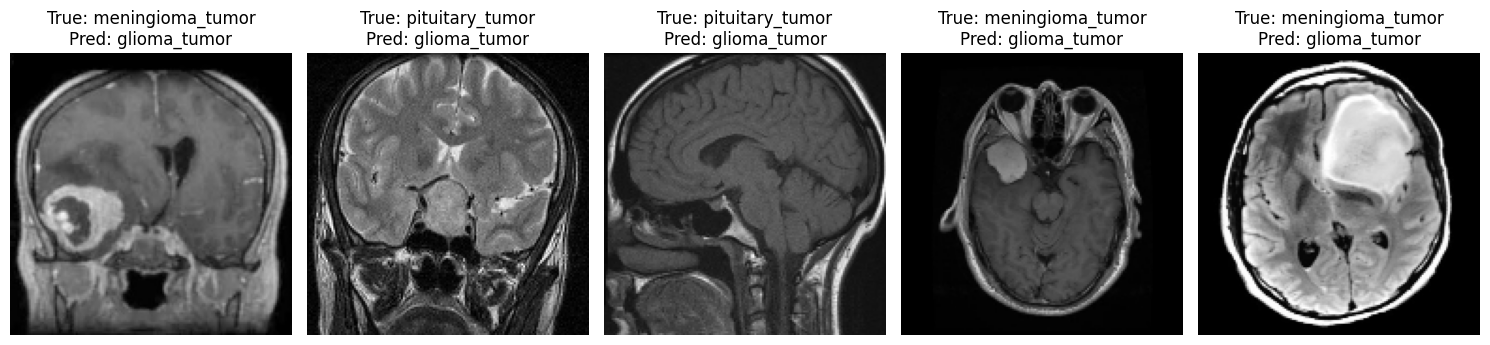

In [23]:
def visualize_predictions(X, y_true, y_pred, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true_label = labels[np.argmax(y_true[idx])]
        pred_label = labels[np.argmax(y_pred[idx])]
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_test, pred, labels)

### Build ResNet50 Model with SGD

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6407 - loss: 0.9563
Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to ResNet50_SGD.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 402s 5s/step - accuracy: 0.6422 - loss: 0.9525 - val_accuracy: 0.7143 - val_loss: 0.8154 - learning_rate: 0.0100
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9326 - loss: 0.2095
Epoch 2: val_accuracy improved from 0.71429 to 0.80952, saving model to ResNet50_SGD.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 388s 5s/step - accuracy: 0.9327 - loss: 0.2092 - val_accuracy: 0.8095 - val_loss: 0.5649 - learning_rate: 0.0100
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9817 - loss: 0.0663
Epoch 3: val_accuracy improved from 0.80952 to 0.84014, saving model to ResNet50_SGD.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 391s 5s/step - accuracy: 0.9817 - loss: 0.0663 - val_accuracy: 0.8401 - val_loss: 0.4837 - learning_rate: 0.0100
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 

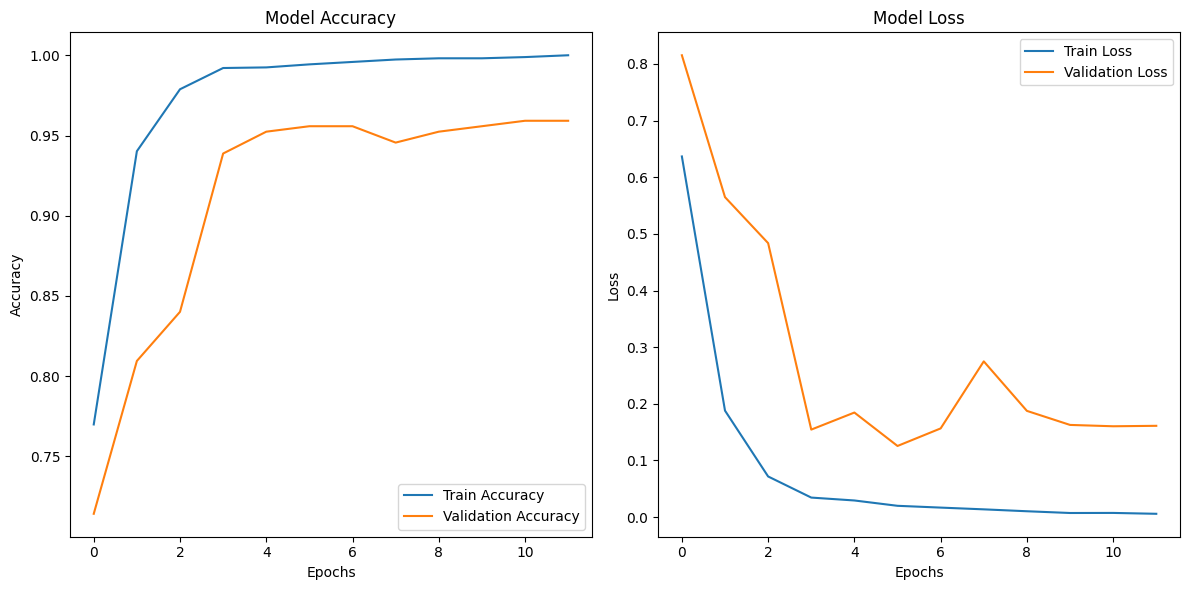

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.97      0.92      0.94        98
        no_tumor       0.98      0.98      0.98        49
meningioma_tumor       0.93      0.95      0.94        93
 pituitary_tumor       0.94      0.98      0.96        87

        accuracy                           0.95       327
       macro avg       0.95      0.96      0.95       327
    weighted avg       0.95      0.95      0.95       327



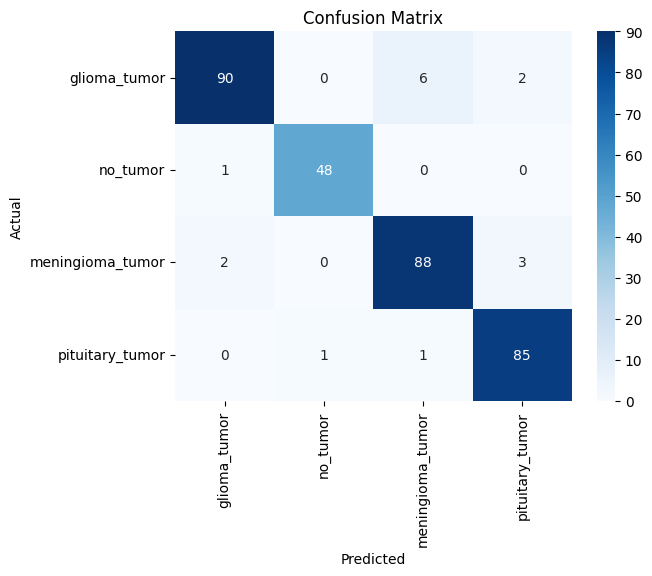

In [24]:
effnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = tf.keras.Sequential([
    effnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("ResNet50_SGD.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=12,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_test_classes, pred_classes, target_names=labels))
cm = confusion_matrix(y_test_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

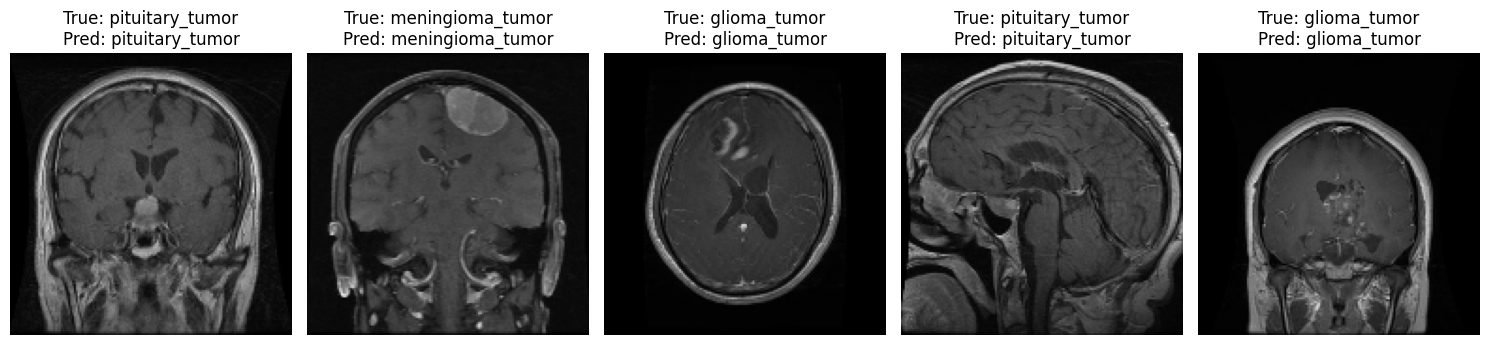

In [25]:
def visualize_predictions(X, y_true, y_pred, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true_label = labels[np.argmax(y_true[idx])]
        pred_label = labels[np.argmax(y_pred[idx])]
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_test, pred, labels)